In [1]:
# this is to make the Jupyter notebook as wide as the screen (on the Mac at least)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format ='retina'

# OLTraj Example 2: Lagrangian evolution of a chlorophyll patch

## Objective
To follow the concentration of chlorophyll within a given water mass that moves from the location where it was observed.
This is an analysis in a Lagrangian reference frame and will be compared to the corresponding Eulerian analysis.

## Input data: 

Assume you have identified an interesting chl feature at a given location and time and you want to follow its evolution for 29 days before and 29 days after the observation. 29 days before and after a given event is the maximum length of a trajectory stored in one OLTraj file. For simplicity, in this example we use this as the maximum length of time we want to follow a given water mass. However, in principle multiple OLTraj files could be used to follow a water mass for longer periods of time.

For this analysis you will use: 
1. Satellite (e.g., Ocean Colour - Climate Change Initiative, OC-CCI) chl images including the intial chl patch as well as areas around it to allow for its advection with time.
2. OLTraj file for the day in which you observed the initial chl patch.

To demonstrate the usefulness of the Lagrangian analysis, we have selected a relatively dynamic region to the south east of Madagascar.

The initial patch we want to follow was located approximately at 28 degress south and 62.5 degrees east and was observed on January 16th, 2006. 


## To do / To check: 


1. Rewrite OLTraj interpolation function to use the xarray interp method
2. How to include all/most of the OC-CCI pixels that fall in the OLTraj pixel?
3. Pixel centers of OLTraj vs OC-CCI?




## Code:

### Import needed modules

In [2]:
import numpy as np
import xarray as xr
import scipy.interpolate as spint
import os
import glob
import datetime as dt
import pandas as pd
# import datetime


import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable



## Define region of interest

In [3]:
#### south east of Madagascar ##########################################################################

# parameters to subset OC-CCI data
region = {'name':'SE_Madagascar','lonmin':55 ,'lonmax':70, 'latmin':-32,'latmax':-24}
var_list = ['chlor_a'] # list of variables to be extracted from the original OC-CCI file (it can be expanded as follows: ['chlor_a', 'Rrs_412'])
chl_min = 0.02 # [mg/m3] this is for plotting
chl_max = 1. # [mg/m3] this is for plotting
chl_thresh = 0.075 # [mg/m3] used to extract OLTraj water parcels (i.e. pixels)

lonini = region['lonmin'] + (region['lonmax']-region['lonmin'])/2.
dlon = 1. # incremnt in longitude (degrees) to define approx area of path. 
latini = region['latmin'] + (region['latmax']-region['latmin'])/2.
dlat = 5. # increment in latitude (degrees) to define approx area of path
centre_lon = 141. # [degrees east]  central longitude for plotting

# coordinates to indentify the area approximately occupied by the observed feature
patch_lonini = 62.8 # central longitude [degrees east]
patch_dlon = 1.2 # increment in longitude [degrees east] to define approx area of path. 
patch_latini = -28.9 # central latitude [degrees north]
patch_dlat = 1. # increment in latitude [degrees north] to define approx area of path

# temporal slice
idate = dt.datetime(2006,1,16) # date of the "initial observation" (i.e., t0)
strdate = idate.strftime('%Y-%m-%d') # string version of the date
tslice1 = (idate - dt.timedelta(days=29)).strftime("%Y-%m-%d")  # maximum start date set at 29 days before idate
tslice2 = (idate + dt.timedelta(days=29)).strftime("%Y-%m-%d")  # maximum end date set at 29 days before idate

# this is the OLTraj time index for the time the initial water patch was observed
# (it is also the central temporal slice in the OLTraj product)
itime0 = 29
#############################################################################



### Read chl data

In [18]:
# open chl dataset using OPENDAP THREDDS (i.e. there is no need to download data files)
GEO_DAILY_THREDDS_string = 'https://rsg.pml.ac.uk/thredds/dodsC/CCI_ALL-v5.0-DAILY'
all_data = xr.open_dataset(GEO_DAILY_THREDDS_string)

# read subsetted data
ds_CHL = all_data[var_list].loc[ {  'time': slice(tslice1, tslice2), 
                                    'lat': slice(region['latmax'], region['latmin']), # latmax before latmin, because of how data are stored in the OC-CCI product
                                    'lon': slice(region['lonmin'], region['lonmax'])}  ]  
# sort along lat dimension, because OC-CCI latitudes are in descending order
ds_CHL = ds_CHL.sortby('lat')


### Read OLTraj data

In [19]:
DIN_AVISO = '/data/datasets/Projects/OLTraj/From_AVISO/OLTraj/Processed/Lagrangian_traj/'
fn_OLT = DIN_AVISO + f'{idate.strftime("%Y")}/{idate.strftime("%Y%m%d")}_oltraj_uv_global.nc'

# open OLTraj file
ds_OLT = xr.open_dataset(fn_OLT)

# # interpolate OLTraj file onto chl coordinates (this is so that we can transport each pixel of the chl image)
# # but perhaps I should interpolate the chl onto OLTraj, otherwise I am making up some trajectories at a resolution we do not have)
# ds_OLT_i = ds_OLT.interp(lat = ds_CHL['lat'], lon = ds_CHL['lon'], method = 'linear')
# ds_OLT_i = ds_OLT_i.reindex(lat=ds_OLT_i.lat[::-1]) # reverse latitude dimension

# # subset OLTraj dataframe    
# ds_OLT_patch = ds_OLT_i.loc[ { 'lat': slice(patch_latini-patch_dlat, patch_latini+patch_dlat), 
#                              'lon': slice(patch_lonini-patch_dlon,  patch_lonini+patch_dlon),     
#                            }  ]    

# subset OLTraj dataframe    
ds_OLT_patch = ds_OLT.loc[ { 'lat': slice(patch_latini-patch_dlat, patch_latini+patch_dlat), 
                             'lon': slice(patch_lonini-patch_dlon,  patch_lonini+patch_dlon),     
                           }  ]    

# set appropriate attributes for OLTraj (needed for plotting)
ds_OLT_patch['time'].attrs["standard_name"] = "time"
ds_OLT_patch['time'].attrs["axis"] =  "T"


In [20]:
## interpolate OC-CCI chl data onto OLTraj grid (this decreases the spatial resolution of the OC-CCI dataset)
# first we create a new OLTraj dataset for the region covered by the OC-CCI data
ds_OLT2 = ds_OLT.loc[ {'lat': slice(region['latmin'], region['latmax']), 
                       'lon': slice(region['lonmin'], region['lonmax'])}  ]

# then we interpolate the OC-CCI data onto the OLTraj product
ds_CHL = ds_CHL.interp(lat=ds_OLT2['lat'], lon=ds_OLT2['lon'])


### Plot chl map with initially observed patch

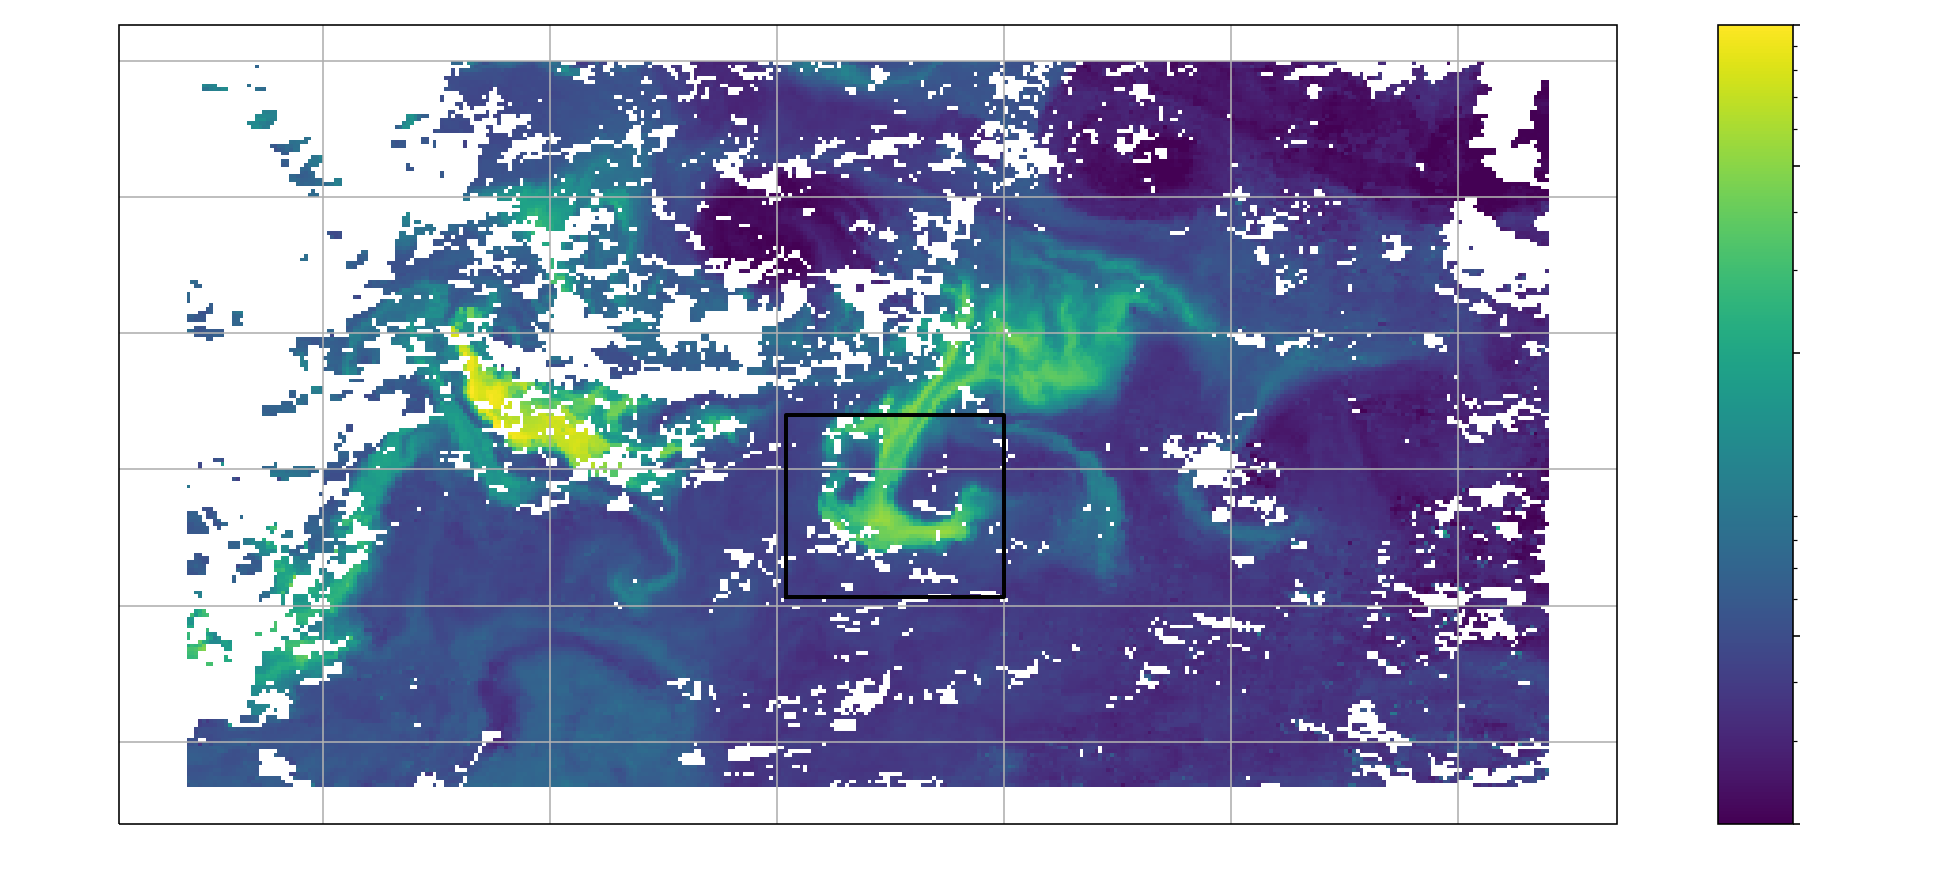

In [21]:
fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(111, projection=ccrs.PlateCarree(  central_longitude=centre_lon   )  )

# extract chl at the time of observation
CHL_t0 = ds_CHL['chlor_a'].sel(time=strdate)

# plot chl on a log scale
pc = ax.pcolormesh(  CHL_t0['lon'], CHL_t0['lat'], CHL_t0, transform=ccrs.PlateCarree(central_longitude=centre_lon), norm=colors.LogNorm(vmin=chl_min, vmax=chl_max)  )

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='w', facecolor='darkgray'))
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabel_style = {'size': 14, 'color': 'w'}
gl.ylabel_style = {'size': 14, 'color': 'w'}
gl.right_labels = False
gl.top_labels = False

ts = pd.to_datetime(str(CHL_t0.time.values)) 
d = ts.strftime('%Y-%m-%d')

divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.7, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(pc, cax=ax_cb)
cb.set_label('Chl [mg m$^{-3}$]', color="w", fontsize=20)
cb.ax.autoscale(False)
cb.set_ticks([0.02, 0.05, 0.2, 0.5, 1])
cb.ax.set_yticklabels(["0.02", "0.05", "0.2", "0.5", "1"], color="w", fontsize=14)


ax.plot([patch_lonini-patch_dlon, patch_lonini+patch_dlon, patch_lonini+patch_dlon, patch_lonini-patch_dlon, patch_lonini-patch_dlon],
        [patch_latini-patch_dlat, patch_latini-patch_dlat, patch_latini+patch_dlat, patch_latini+patch_dlat, patch_latini-patch_dlat], 
        lw=2, c='k',transform=ccrs.PlateCarree(central_longitude=centre_lon))



The patch with relatively high chl (green-yellow colours) inside the black rectangle is the chl feature we want to follow.
<br/><br/>

### Identify OLTraj data within the patch
To do this, we select trajectories that are within the black rectangle with `chl` values greater than `chl_thresh`.

We will then need to interpolate the chl data onto the same spatial grid as the OLTraj data.


In [22]:
# function to interpolate chl field onto OLTraj product at a given time
# Crucial point: in this example, and in this fuction, we assume that chl and OLTraj share the same time coordinate 
def interp_chl_on_OLTraj(ds_CHL, ds_OLT, interp_time):
    # ds_CHL: xarray dataset with the chl data (if working on a small region, slice these arrays before this function to speed things up)
    # ds_OLT: xarray dataset with the OLTraj product
    # interp_time: date string at which we want the interpolated chl onto the OLTraj geographic coordinate
    
    # Since input field is on a regular grid but the trajectory positions are not,
    # we can use RegularGridInterpolator from scipy.interpolate
    
    # Slice chl data closest to the given time (see xarray documentation for "closest")
    CHL_it = ds_CHL['chlor_a'].sel(time=interp_time)
    
    # Extract chl coordinates 
    lonCHL = CHL_it['lon'].values
    latCHL = CHL_it['lat'].values
    
#     # Need to flip lat and chl matrix because OCCCI lat are in descending order
#     latCHL = np.flipud(latCHL)
#     CHL = np.flipud(CHL_it.values)
    CHL = CHL_it.values

    # Create the interpolation function
    finterp = spint.RegularGridInterpolator((latCHL,lonCHL), CHL, method='linear')
        
    # extract OLTraj data closest to the given time (see xarray documentation for "closest")
    latOLT = ds_OLT['trajlat'].sel(time=interp_time).values
    lonOLT = ds_OLT['trajlon'].sel(time=interp_time).values

    # Get lat and lon dimensions used later to reshpe 1d array and 2d array
    londim = ds_OLT['lon'].shape
    latdim = ds_OLT['lat'].shape
    
    # Convert 2D OLTraj coordinates into 1D arrays
    latOLT = latOLT.ravel()
    lonOLT = lonOLT.ravel()

    # Interpolate Chl over trajectory positions
    intCHL = finterp(np.array([latOLT,lonOLT]).T) # Need to transpose to have lat and lon as columns of the input matrix
    
    # Convert into 2D matrix
    intCHL = intCHL.reshape(latdim+londim)
    
    return intCHL 

In [23]:
# Interpolate Chl on trajectory positions at strdate
znew = interp_chl_on_OLTraj(ds_CHL, ds_OLT_patch, strdate)

# select pixels with chl > chl_thresh to define water patches to follow in the LAgrangian framework
igood = np.where(znew > chl_thresh)

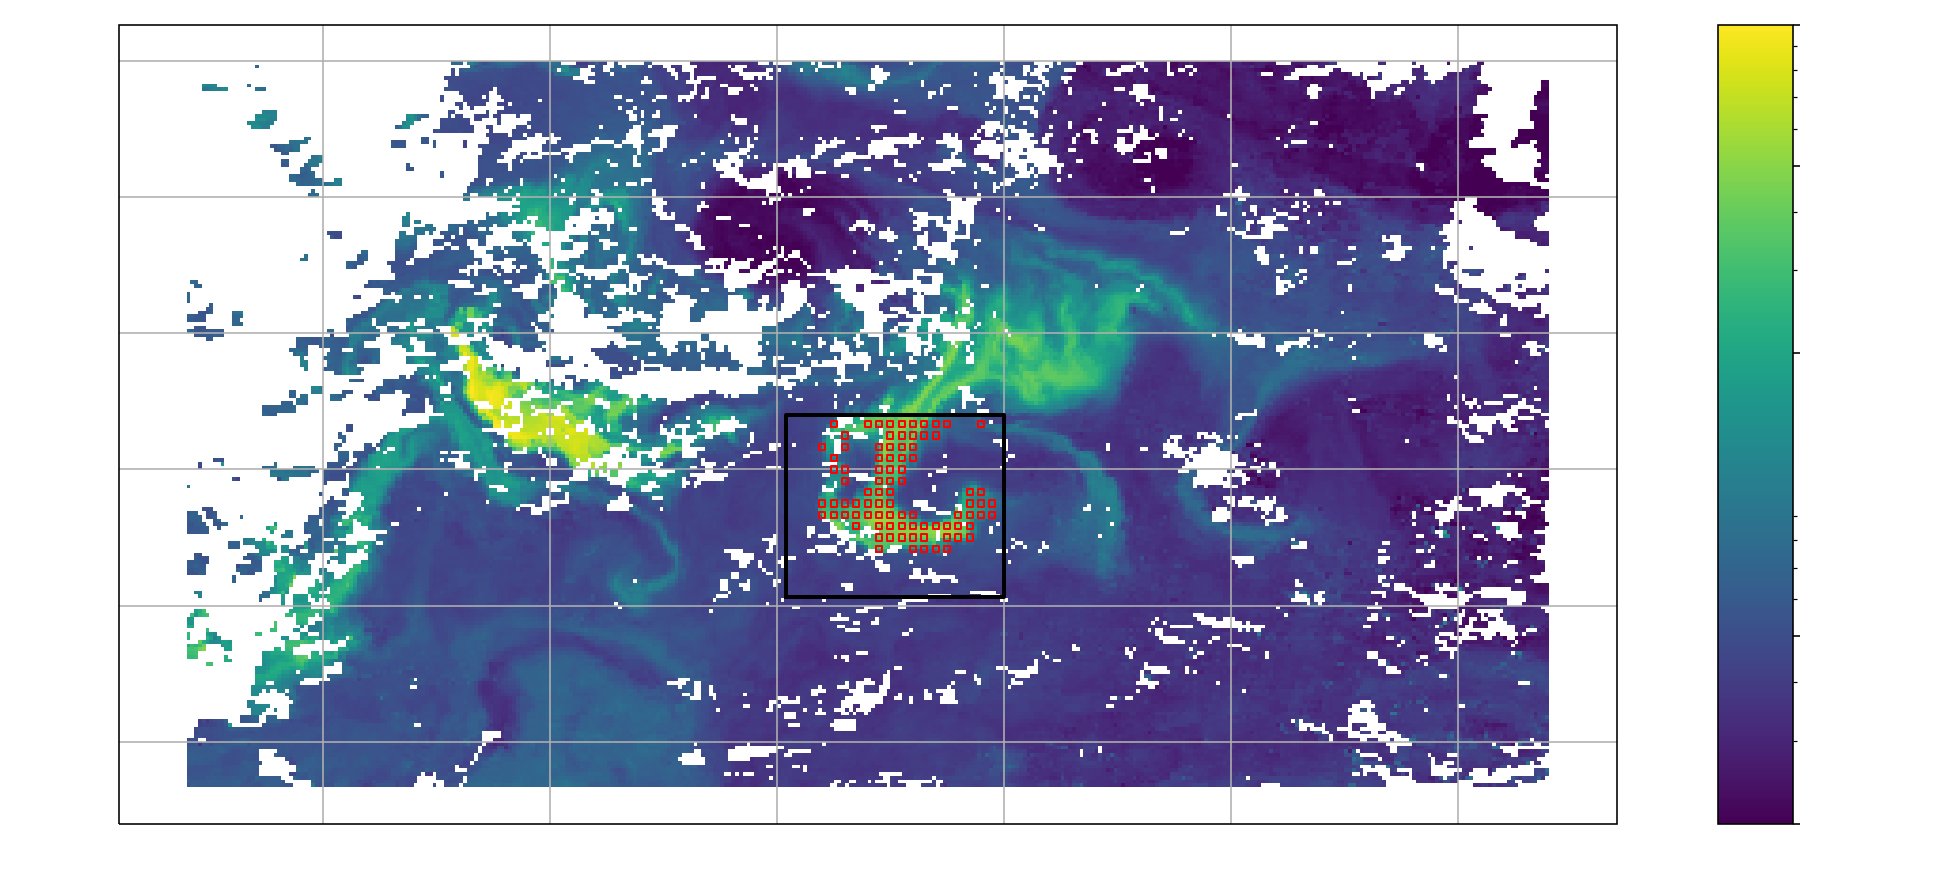

In [24]:
# plot selected OLTraj pixels over the chl patch
fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(111, projection=ccrs.PlateCarree(  central_longitude=centre_lon   )  )

# extract chl at the time of observation
CHL_t0 = ds_CHL['chlor_a'].sel(time=strdate)

# plot chl on a log scale
pc = ax.pcolormesh(  CHL_t0['lon'], CHL_t0['lat'], CHL_t0, transform=ccrs.PlateCarree(central_longitude=centre_lon), norm=colors.LogNorm(vmin=chl_min, vmax=chl_max)  )

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='w', facecolor='darkgray'))
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabel_style = {'size': 14, 'color': 'w'}
gl.ylabel_style = {'size': 14, 'color': 'w'}
gl.right_labels = False
gl.top_labels = False

ts = pd.to_datetime(str(CHL_t0.time.values)) 
d = ts.strftime('%Y-%m-%d')

divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.7, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(pc, cax=ax_cb)
cb.set_label('Chl [mg m$^{-3}$]', color="w", fontsize=20)
cb.ax.autoscale(False)
cb.set_ticks([0.02, 0.05, 0.2, 0.5, 1])
cb.ax.set_yticklabels(["0.02", "0.05", "0.2", "0.5", "1"], color="w", fontsize=14)


ax.scatter(ds_OLT_patch['trajlon'].values[itime0,igood[0],igood[1]], 
           ds_OLT_patch['trajlat'].values[itime0,igood[0],igood[1]], marker="s", s=10,
           transform=ccrs.PlateCarree(central_longitude=centre_lon), 
           facecolor='none', edgecolors="r", zorder=60)

ax.plot([patch_lonini-patch_dlon,patch_lonini+patch_dlon,patch_lonini+patch_dlon,patch_lonini-patch_dlon,patch_lonini-patch_dlon],
        [patch_latini-patch_dlat,patch_latini-patch_dlat,patch_latini+patch_dlat,patch_latini+patch_dlat,patch_latini-patch_dlat], 
        lw=2, c='k',transform=ccrs.PlateCarree(central_longitude=centre_lon))



The red squares represent the locations of the OLTraj pixels selected to track the chl patch.
<br/><br/>

**Now we plot the backward (pink) and forward (cyan) trajectories on top of the chl image at the time of observation to see where the patch came from and where it moved**

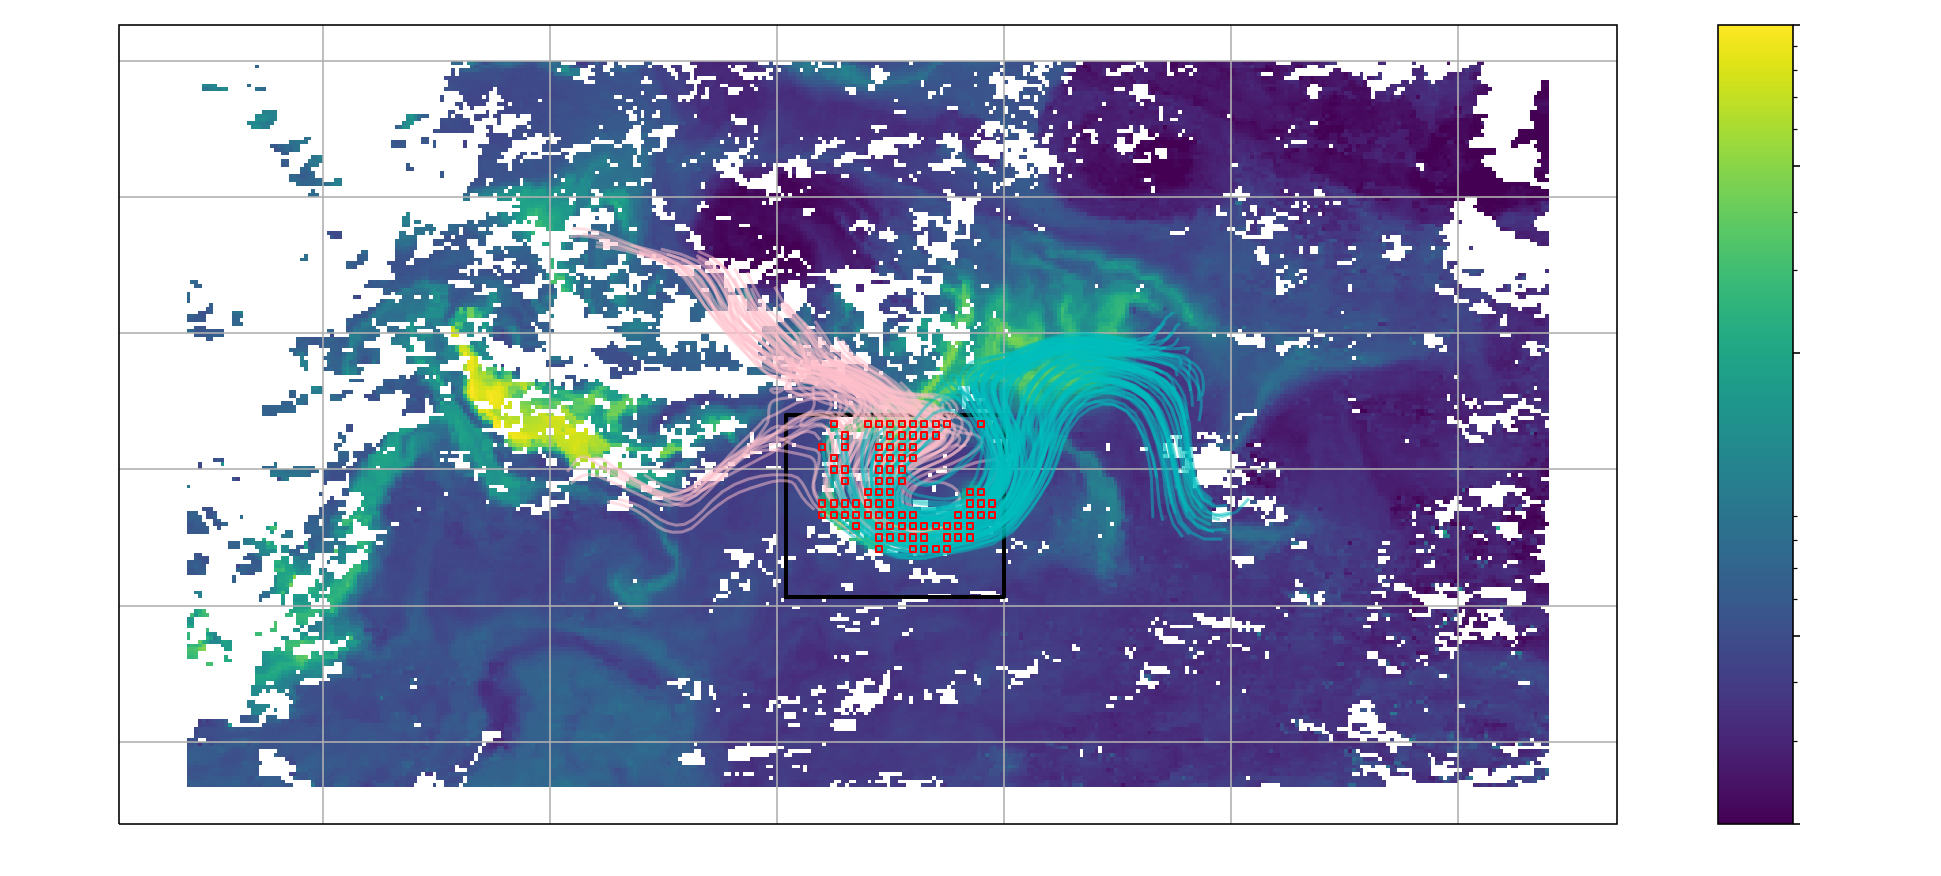

In [25]:
fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(111, projection=ccrs.PlateCarree(  central_longitude=centre_lon   )  )

# extract chl at the time of observation
CHL_t0 = ds_CHL['chlor_a'].sel(time=strdate)

# plot chl on a log scale
pc = ax.pcolormesh(  CHL_t0['lon'], CHL_t0['lat'], CHL_t0, transform=ccrs.PlateCarree(central_longitude=centre_lon), norm=colors.LogNorm(vmin=chl_min, vmax=chl_max)  )

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='w', facecolor='darkgray'))
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabel_style = {'size': 14, 'color': 'w'}
gl.ylabel_style = {'size': 14, 'color': 'w'}
gl.right_labels = False
gl.top_labels = False

ts = pd.to_datetime(str(CHL_t0.time.values)) 
d = ts.strftime('%Y-%m-%d')
# ax.set_title(d+"\n", fontsize=20, color="w")

divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.7, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(pc, cax=ax_cb)
cb.set_label('Chl [mg m$^{-3}$]', color="w", fontsize=20)
cb.ax.autoscale(False)
cb.set_ticks([0.02, 0.05, 0.2, 0.5, 1])
cb.ax.set_yticklabels(["0.02", "0.05", "0.2", "0.5", "1"], color="w", fontsize=14)


ax.scatter(ds_OLT_patch['trajlon'].values[itime0,igood[0],igood[1]], 
           ds_OLT_patch['trajlat'].values[itime0,igood[0],igood[1]], marker="s", s=10,
           transform=ccrs.PlateCarree(central_longitude=centre_lon), 
           facecolor='none', edgecolors="r", zorder=60)

ax.plot([patch_lonini-patch_dlon,patch_lonini+patch_dlon,patch_lonini+patch_dlon,patch_lonini-patch_dlon,patch_lonini-patch_dlon],
        [patch_latini-patch_dlat,patch_latini-patch_dlat,patch_latini+patch_dlat,patch_latini+patch_dlat,patch_latini-patch_dlat], 
        lw=2, c='k',transform=ccrs.PlateCarree(central_longitude=centre_lon));

ax.plot(ds_OLT_patch['trajlon'].values[0:itime0,igood[0],igood[1]], 
           ds_OLT_patch['trajlat'].values[0:itime0,igood[0],igood[1]], 
           transform=ccrs.PlateCarree(central_longitude=centre_lon), 
           color='pink', alpha=0.5);

ax.plot(ds_OLT_patch['trajlon'].values[itime0:,igood[0],igood[1]], 
           ds_OLT_patch['trajlat'].values[itime0:,igood[0],igood[1]], 
           transform=ccrs.PlateCarree(central_longitude=centre_lon), 
           color='c', alpha=0.5);


**Now we generate a dynamic plot showing the location of the initially observed patch (black squares) and the location of the patch at any given day before and after the initial observation (red squares).**

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
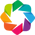

:DynamicMap   [time]
   :Overlay
      .Image.I   :Image   [lon,lat]   (chlor_a)
      .Points.I  :Points   [lon,lat]
      .Points.II :Points   [lon,lat]

In [26]:
import holoviews as hv
from holoviews import opts
import hvplot.pandas
import hvplot.xarray

hv.extension('bokeh')

startdate = tslice1
enddate = tslice2


# convert ds_OLT_patch to a pandas DataFrame
trajlat = ds_OLT_patch.sel(time = slice(startdate, enddate)).trajlat.values[:,igood[0], igood[1]]
trajlon = ds_OLT_patch.sel(time = slice(startdate, enddate)).trajlon.values[:,igood[0], igood[1]]
time = pd.to_datetime(ds_OLT_patch.sel(time = slice(startdate, enddate)).time.values) #- dt.timedelta(days=1)


# initialize datetime64 array of the same size as trajlon
tmp = np.Datetime64().astype('M8[ns]')
t64 = np.tile(tmp, [trajlon.shape[0], trajlon.shape[1]])

# fill datetime64 array with times
for ic in range(trajlon.shape[1]):
    t64[:,ic] = time


# create a pandas dataframe for oltraj dataset
olt_pd = pd.DataFrame({"lat" : np.ravel(trajlat), 
                   "lon" : np.ravel(trajlon), 
                   "time": np.ravel(t64) 
                  })        


#### create overlay of two datasets
# create chl object
chl_hv = ds_CHL.sel(time=slice(startdate, enddate)).\
        hvplot( groupby='time', logz=True, colorbar=True,  cmap='viridis').\
                redim.range(lon = (55, 70), 
                            lat = (-32,  -24),
                            chlor_a = (chl_min, chl_max), 
                           )
# create OLT object of central date
t_default = np.datetime64(idate)
olt_hv0 = olt_pd.loc[(olt_pd['time']==t_default)].\
            hvplot.points('lon', 'lat', marker='s', line_color='k', line_width=0.5, fill_alpha=0, size=15)  




# create olt object
olt_hv = olt_pd.hvplot.points('lon', 'lat', groupby='time', marker='s', line_color='red', line_width=0.5, fill_alpha=0, size=15)  

# create overlay
overlay = chl_hv * olt_hv0 * olt_hv

# set location of slider to below the plot
hv.output(widget_location='bottom')


# set size of plot and starting time, and visualise
overlay.opts( width = 800, 
              height = 400).redim.default(time=t_default)




You can change the time by moving the slide bar with your mouse or by clicking on it and then using the arrow keys (note: the first time you will change dates it will take longer, but after that images should be updating more rapidly). Red boxes correspond to the location of the patch at the specific time plotted. Back boxes represent the location of the "initial observation" on 2006-01-16.
<br/><br/>

**Next, we will extract and compare the Lagrangian and Eulerian time series.**

In [27]:
###### Extract Lagrangian time series of Chl
# Interpolate ds_CHL on the OLT positions at each timestep
# We need to use the full chl field because particles might be advected outside the chl domain used for the plot
# (if no chl data are available for a given location, then the interpolation function will return an error)
for ii, it in enumerate(ds_CHL['time'].values):
    _CHL_Lag = interp_chl_on_OLTraj(ds_CHL, ds_OLT_patch, it)
    if ii == 0:
        CHL_Lag = _CHL_Lag[None,...]
    else:
        CHL_Lag = np.concatenate((CHL_Lag, _CHL_Lag[None,...]), axis=0)
        
# CHL_Lag is an array of points with two dimensions: the first dimension (length = 59) is time, the second dimension
# (length = 87) contains the chl values interpolated onto the OLTraj pixels (i.e., black rectangles in the above figures) 
# as they moved over time. 
# 
# CHL_Lag[29,:] are the chl values observed on 2006-01-16 on the OLTraj pixels selected.
# CHL_Lag[28,:] are the chl values observed on 2006-01-15 on the same OLTraj pixels, but accounting 
#               for the movement of the water masses
# CHL_Lag[30,:] are the chl values observed on 2006-01-17 on the same OLTraj pixels, but accounting 
#               for the movement of the water masses
        
        
# Select only particles within the given chl threshold at time0 (i.e., idate/strdate)
CHL_Lag = CHL_Lag[:, igood[0], igood[1]] 


In [33]:
###### Extract Eulerian time series of Chl
# interpolate ds_CHL onto the same coordinates as ds_OLT_patch
ds_interp_CHL = ds_CHL.interp(lat=ds_OLT_patch['lat'], lon=ds_OLT_patch['lon'])

# extract Eulerian time series for the igood points
CHL_Eul = ds_interp_CHL['chlor_a'].values[:, igood[0], igood[1]]

/users/modellers/gdal/miniconda3/envs/OLTraj_env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/users/modellers/gdal/miniconda3/envs/OLTraj_env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


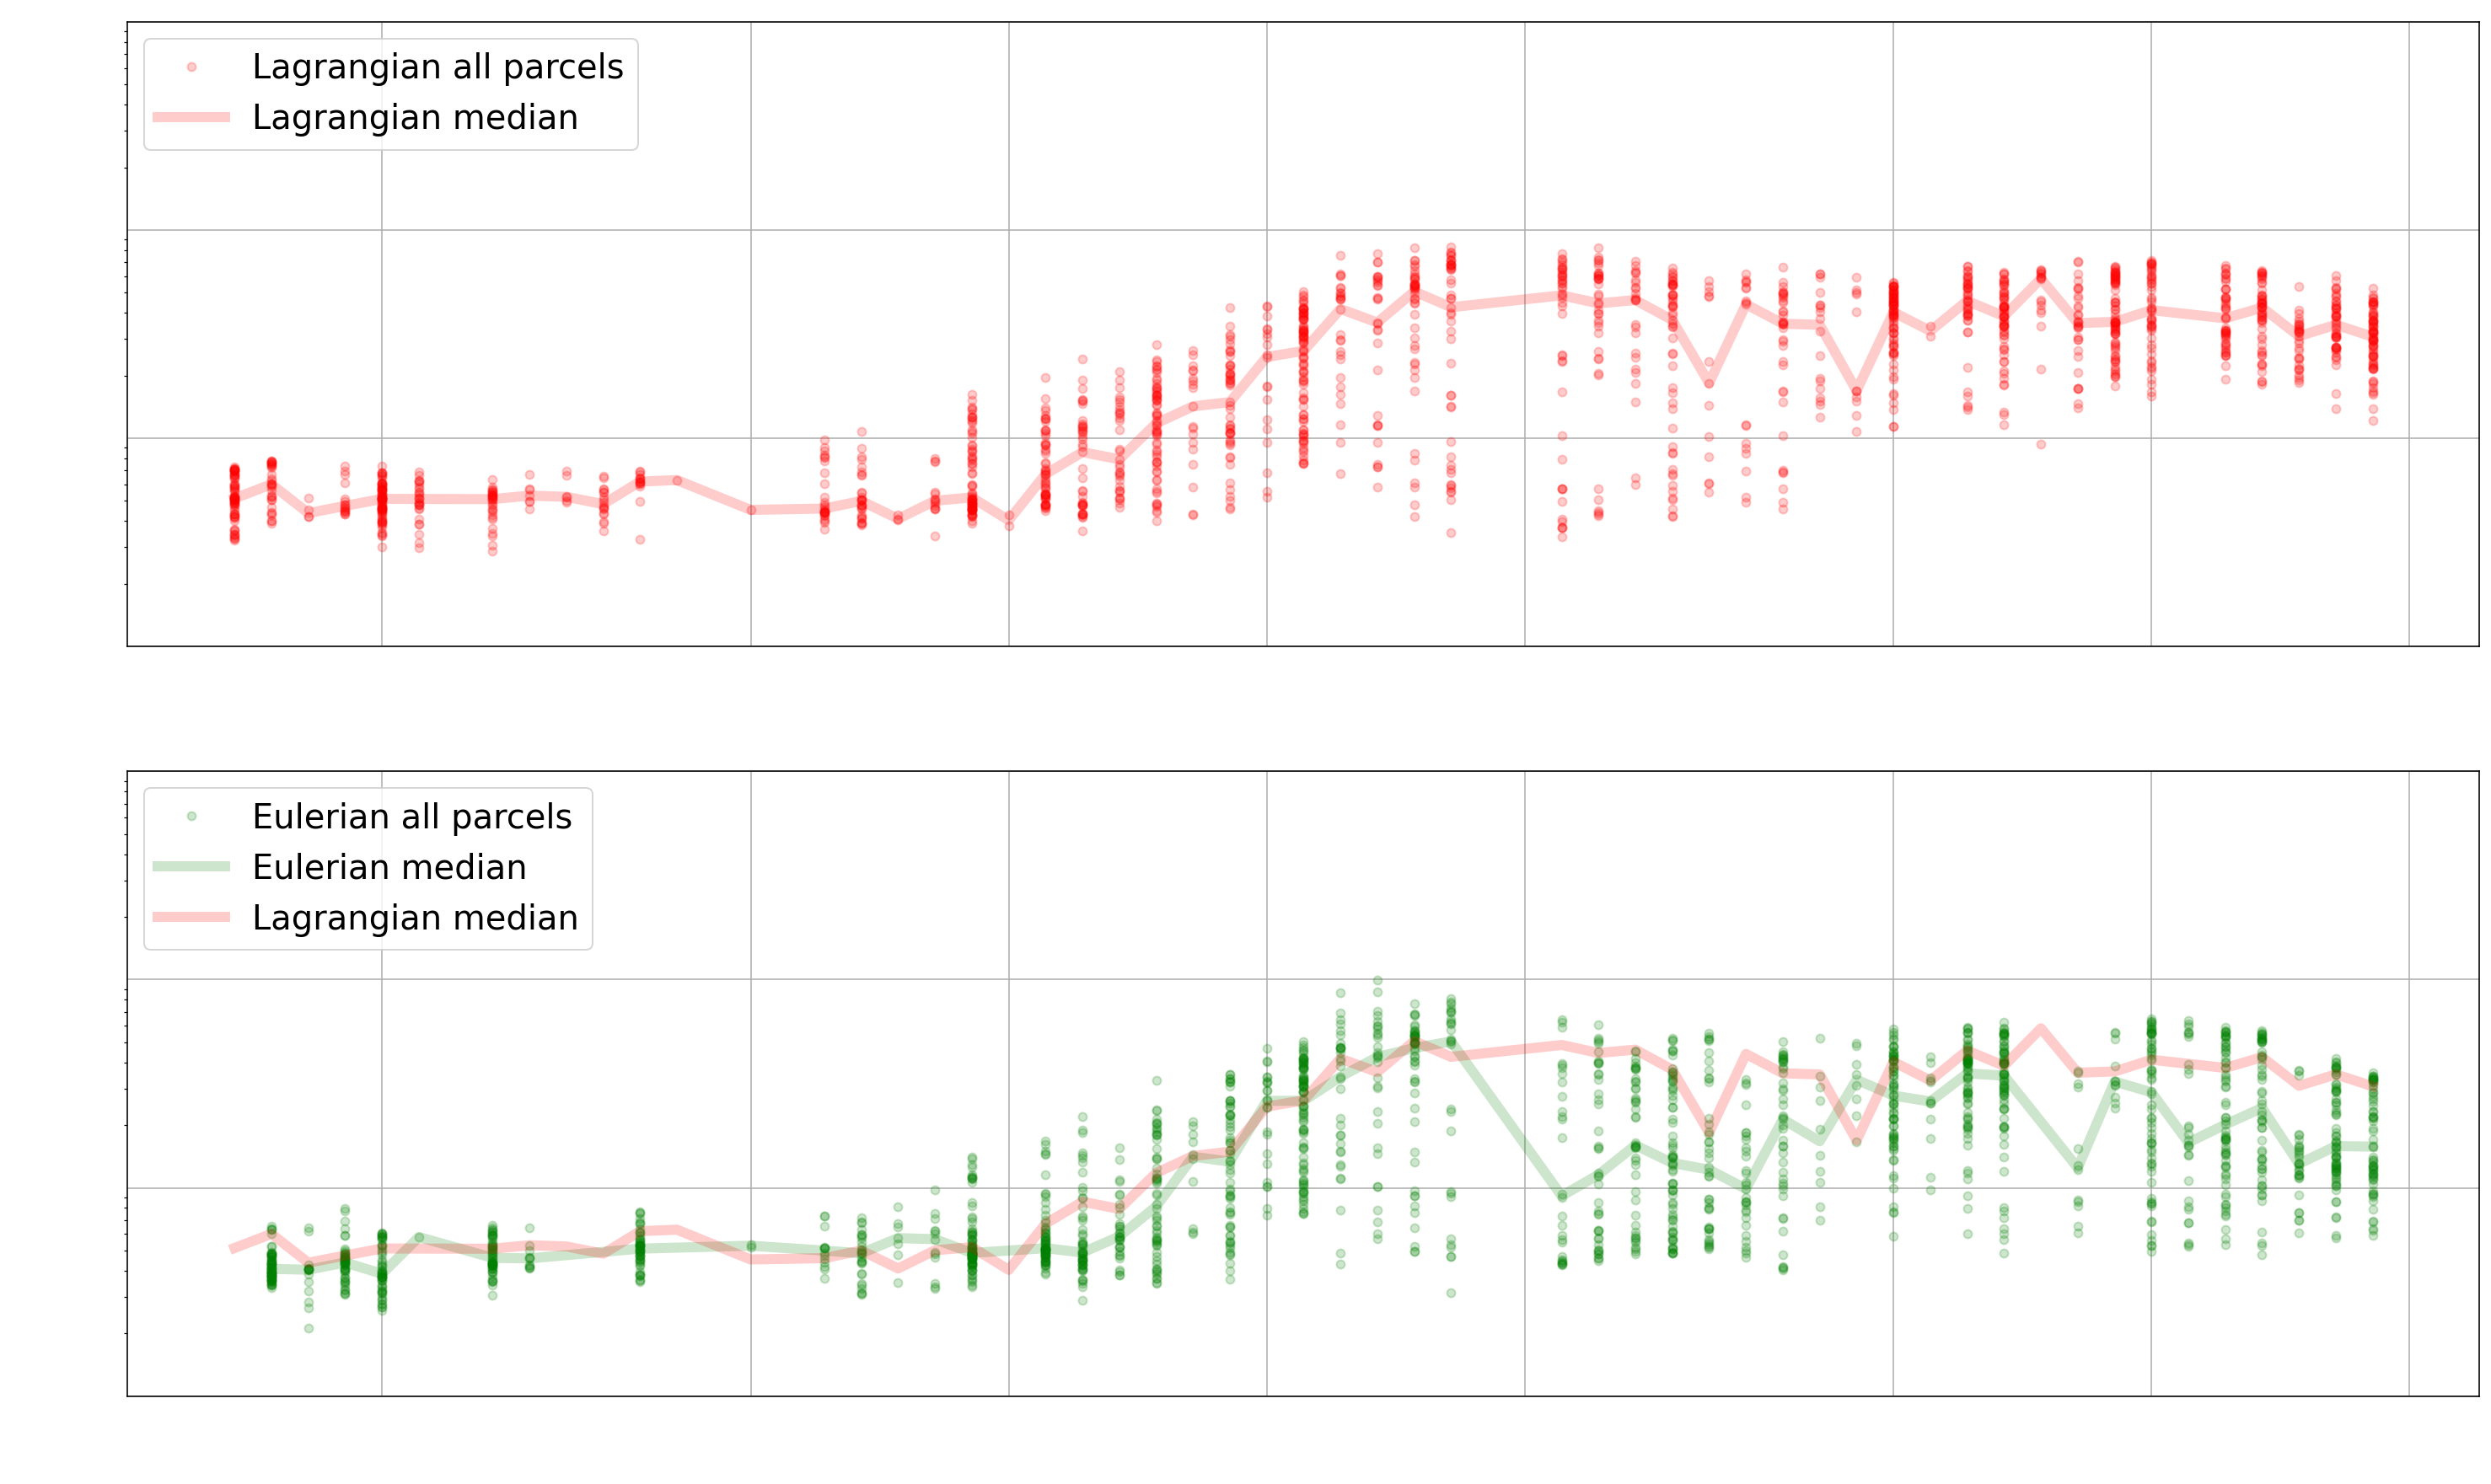

In [34]:
# now plot both the Eulerian and Lagrangian time series
fig = plt.figure(figsize=(25,15))
ax = fig.add_subplot(211)

# compute time series of medians
CHL_Lag_med = np.nanmedian(CHL_Lag, axis=1)
inan2 = np.isnan(CHL_Lag_med)
CHL_Lag_med = CHL_Lag_med[~inan2]

ax.plot(ds_CHL['time'], CHL_Lag, 'ro', label='Lagrangian all parcels', ms=5, alpha=0.2)
ax.plot(ds_CHL['time'][~inan2], CHL_Lag_med, 'r', label='Lagrangian median', lw=6, alpha=0.2)


ax.set_xlabel("date", fontsize=20, color='w')
ax.set_ylabel("Chl [mg m$^{-3}$]", fontsize=20, color='w')
ax.tick_params(axis='x', colors='w')
ax.tick_params(axis='y', colors='w')
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)

ax.legend(fontsize=20)

# this is to only plot the legend for the median value
# extract from the legend labels only the median values
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-2:], labels[-2:], fontsize=20, loc='upper left')
ax.grid('on')

ax.set_ylim(0.01,10)
ax.set_yscale('log')


### Plot Eulerian time series
ax2 = fig.add_subplot(212)

# compute time series of medians
CHL_Eul_med = np.nanmedian(CHL_Eul, axis=1)
inan = np.isnan(CHL_Eul_med)
CHL_Eul_med = CHL_Eul_med[~inan]

ax2.plot(ds_CHL['time'],CHL_Eul,'go', label='Eulerian all parcels', ms=5, alpha=0.2)

ax2.plot(ds_CHL['time'][~inan], CHL_Eul_med, 'g', label='Eulerian median', lw=6, alpha=0.2)
ax2.plot(ds_CHL['time'][~inan2], CHL_Lag_med, 'r', label='Lagrangian median', lw=6, alpha=0.2)
ax2.grid('on')

ax2.set_ylim(0.01,10)
ax2.set_yscale('log')

ax2.set_xlabel("date", fontsize=20, color='w')
ax2.set_ylabel("Chl [mg m$^{-3}$]", fontsize=20, color='w')
ax2.tick_params(axis='x', colors='w')
ax2.tick_params(axis='y', colors='w')
plt.setp(ax2.get_xticklabels(), fontsize=14)
plt.setp(ax2.get_yticklabels(), fontsize=14)

# this is to only plot the legend for the median value
# extract from the legend labels only the median values
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[-3:], labels[-3:], fontsize=20, loc='upper left')


Note how the Lagrangian and Eulerian time series (red and green lines, respectively) diverge after the initial observation (2006-01-16) due to the movement of the water masses. Before 2006-01-16 chl value were very low and it is more difficult to see differences.